---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
---


# Sequential Parameter Optimization:  Gaussian Process Models {#sec-gaussian-process-models}

This chapter analyzes differences between the `Kriging` implementation in `spotpython` and the `GaussianProcessRegressor` in `scikit-learn`.


In [1]:
import numpy as np
from math import inf
from spotpython.fun.objectivefunctions import analytical
from spotpython.design.spacefilling import SpaceFilling
from spotpython.spot import spot
from spotpython.build.kriging import Kriging
from scipy.optimize import shgo
from scipy.optimize import direct
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import math as m
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

Seed set to 123


## Gaussian Processes Regression: Basic Introductory `scikit-learn` Example

* This is the example from [scikit-learn: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html)

* After fitting our model, we see that the hyperparameters of the kernel have been optimized. 
* Now, we will use our kernel to compute the mean prediction of the full dataset and plot the 95% confidence interval.

### Train and Test Data


In [2]:
X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

### Building the Surrogate With `Sklearn`

* The model building with `sklearn` consisits of three steps:
    1. Instantiating the model, then
    2. fitting the model (using `fit`), and
    3. making predictions (using `predict`)


In [3]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

### Plotting the `Sklearn`Model


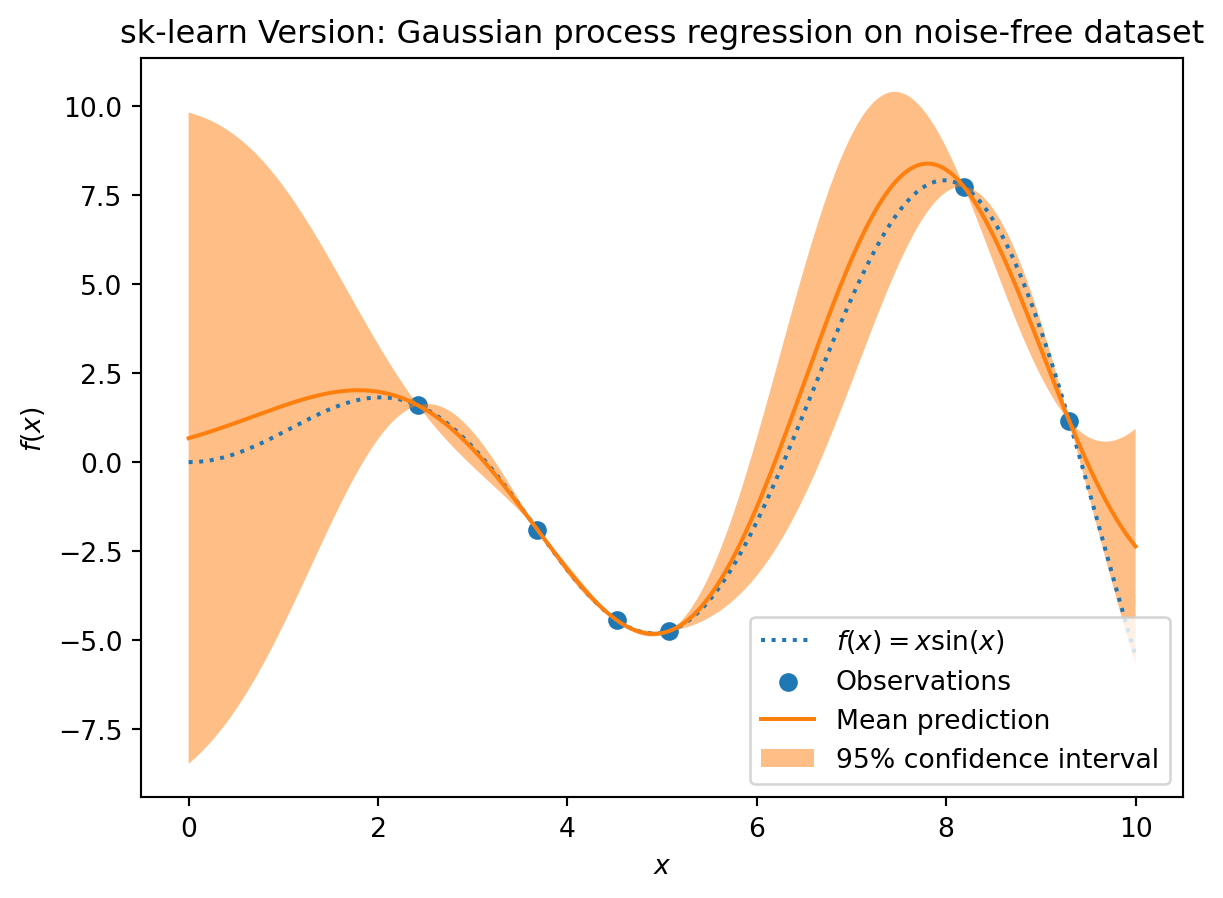

In [4]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("sk-learn Version: Gaussian process regression on noise-free dataset")

### The `spotpython` Version

* The `spotpython` version is very similar:
    1. Instantiating the model, then
    2. fitting the model and
    3. making predictions (using `predict`).


In [5]:
S = Kriging(name='kriging',  seed=123, log_level=50, cod_type="norm")
S.fit(X_train, y_train)
S_mean_prediction, S_std_prediction, S_ei = S.predict(X, return_val="all")

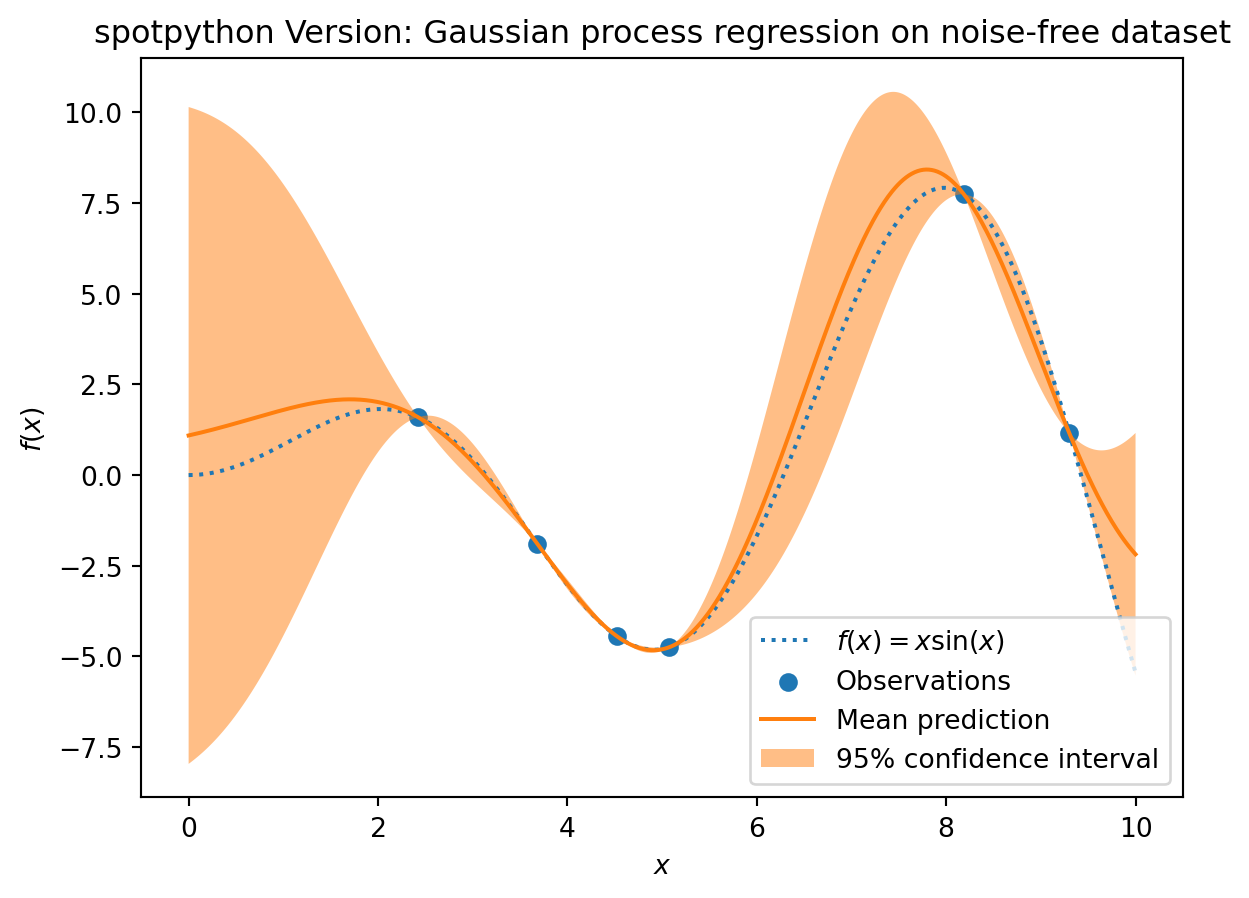

In [6]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, S_mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    S_mean_prediction - 1.96 * S_std_prediction,
    S_mean_prediction + 1.96 * S_std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("spotpython Version: Gaussian process regression on noise-free dataset")

### Visualizing the Differences Between the `spotpython` and the `sklearn` Model Fits


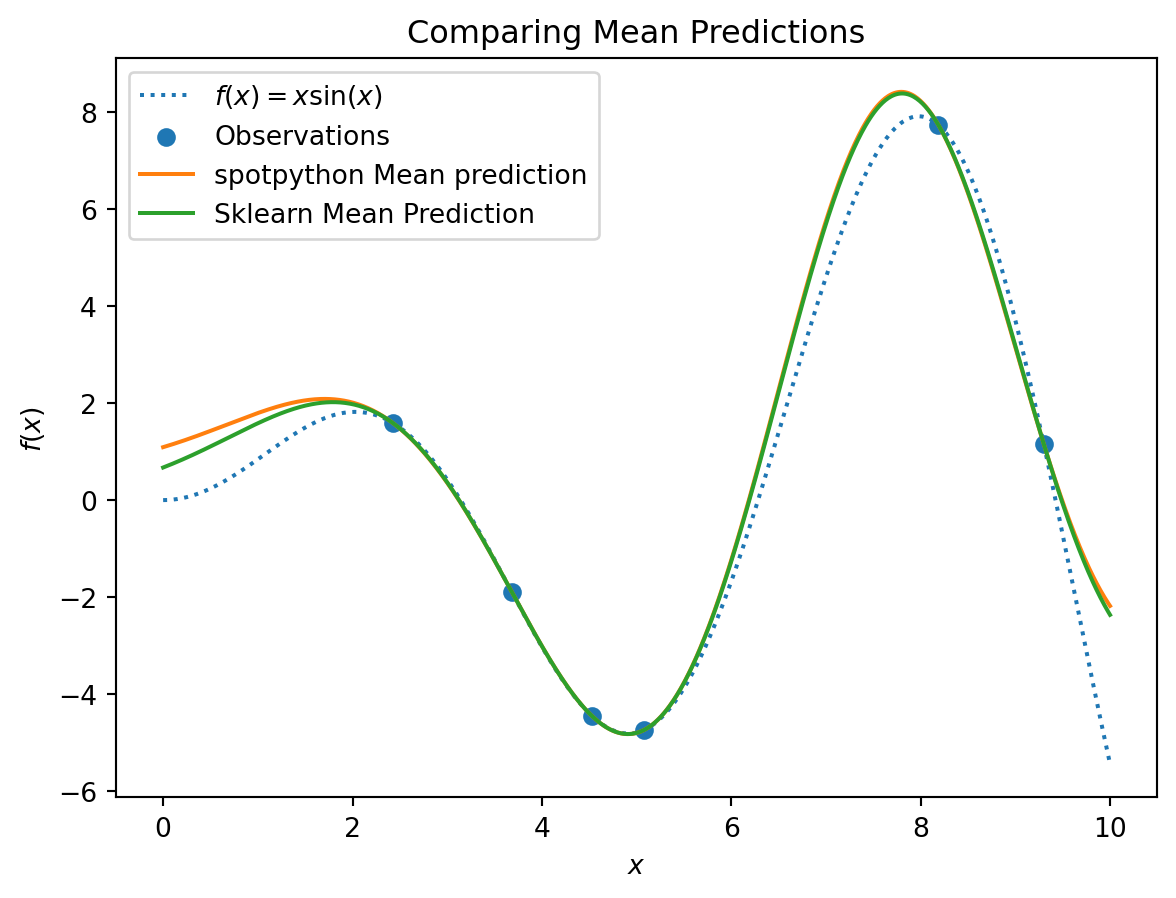

In [7]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, S_mean_prediction, label="spotpython Mean prediction")
plt.plot(X, mean_prediction, label="Sklearn Mean Prediction")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Comparing Mean Predictions")

## Exercises

### `Schonlau Example Function`

* The Schonlau Example Function is based on sample points only (there is no analytical function description available):


In [8]:
X = np.linspace(start=0, stop=13, num=1_000).reshape(-1, 1)
X_train = np.array([1., 2., 3., 4., 12.]).reshape(-1,1)
y_train = np.array([0., -1.75, -2, -0.5, 5.])

* Describe the function.
* Compare the two models that were build using the `spotpython` and the `sklearn` surrogate.
* Note: Since there is no analytical function available, you might be interested in adding some points and describe the effects.

### `Forrester Example Function`

* The Forrester Example Function is defined as follows:

    `f(x) = (6x- 2)^2 sin(12x-4) for x in [0,1].`

* Data points are generated as follows:


In [9]:
from spotpython.utils.init import fun_control_init
X = np.linspace(start=-0.5, stop=1.5, num=1_000).reshape(-1, 1)
X_train = np.array([0.0, 0.175, 0.225, 0.3, 0.35, 0.375, 0.5,1]).reshape(-1,1)
fun = analytical().fun_forrester
fun_control = fun_control_init(sigma = 0.1)
y = fun(X, fun_control=fun_control)
y_train = fun(X_train, fun_control=fun_control)

Seed set to 123


* Describe the function.
* Compare the two models that were build using the `spotpython` and the `sklearn` surrogate.
* Note: Modify the noise level (`"sigma"`), e.g., use a value of `0.2`, and compare the two models.


In [10]:
fun_control = fun_control_init(sigma = 0.2)

Seed set to 123


### `fun_runge Function (1-dim)`

* The Runge function is defined as follows:

  `f(x) = 1/ (1 + sum(x_i))^2`

* Data points are generated as follows:


In [11]:
gen = SpaceFilling(1)
rng = np.random.RandomState(1)
lower = np.array([-10])
upper = np.array([10])
fun = analytical().fun_runge
fun_control = fun_control_init(sigma = 0.025)
X_train = gen.scipy_lhd(10, lower=lower, upper = upper).reshape(-1,1)
y_train = fun(X, fun_control=fun_control)
X = np.linspace(start=-13, stop=13, num=1000).reshape(-1, 1)
y = fun(X, fun_control=fun_control)

Seed set to 123


* Describe the function.
* Compare the two models that were build using the `spotpython` and the `sklearn` surrogate.
* Note: Modify the noise level (`"sigma"`), e.g., use a value of `0.05`, and compare the two models.


In [12]:
fun_control = fun_control_init(sigma = 0.5)

Seed set to 123


### `fun_cubed (1-dim)`

* The Cubed function is defined as follows:

    `np.sum(X[i]** 3)`

* Data points are generated as follows:


In [13]:
gen = SpaceFilling(1)
rng = np.random.RandomState(1)
fun_control = fun_control_init(sigma = 0.025,
                lower = np.array([-10]),
                upper = np.array([10]))
fun = analytical().fun_cubed
X_train = gen.scipy_lhd(10, lower=lower, upper = upper).reshape(-1,1)
y_train = fun(X, fun_control=fun_control)
X = np.linspace(start=-13, stop=13, num=1000).reshape(-1, 1)
y = fun(X, fun_control=fun_control)

Seed set to 123


* Describe the function.
* Compare the two models that were build using the `spotpython` and the `sklearn` surrogate.
* Note: Modify the noise level (`"sigma"`), e.g., use a value of `0.05`, and compare the two models.


In [14]:
fun_control = fun_control_init(sigma = 0.025)

Seed set to 123


### The Effect of Noise

How does the behavior of the `spotpython` fit changes when the argument `noise` is set to `True`, i.e.,
    
`S = Kriging(name='kriging',  seed=123, n_theta=1, noise=True)`

is used?
